### Ivor's notes
THis is a highly acclaimed notebook: https://www.kaggle.com/code/adizafar/predictions-using-ml-and-dl-methods

Specificlly dataset from https://www.kaggle.com/datasets/spsayakpaul/arxiv-paper-abstracts/

Documented https://medium.com/analytics-vidhya/building-multi-label-text-classifiers-for-arxiv-paper-abstract-dataset-1cc5353b3e96



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
papers = pd.read_csv('arxiv-dataset/arxiv_data.csv')
papers.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [3]:
print(papers.shape)


(51774, 3)


__Commentry__: Remove the single quotes from each of the terms and convert literals to lists (use regex and the literal_eval function )

In [4]:
description_category = papers[['terms','summaries','titles']]
description_category['terms'] = description_category['terms'].apply(lambda x: ast.literal_eval(x))
#description_category['terms'] =  description_category['terms'].apply(lambda x: re.sub(r'([^)]*)', '',x)
description_category.head()


,terms,summaries,titles
0,"[cs.CV, cs.LG]",Stereo matching is one of the widely used tech...,Survey on Semantic Stereo Matching / Semantic ...
1,"[cs.CV, cs.AI, cs.LG]",The recent advancements in artificial intellig...,FUTURE-AI: Guiding Principles and Consensus Re...
2,"[cs.CV, cs.AI]","In this paper, we proposed a novel mutual cons...",Enforcing Mutual Consistency of Hard Regions f...
3,[cs.CV],Consistency training has proven to be an advan...,Parameter Decoupling Strategy for Semi-supervi...
4,"[cs.CV, cs.LG]","To ensure safety in automated driving, the cor...",Background-Foreground Segmentation for Interio...


__Commentry__: independantly of this notebook, had calculated that highest no of label values in single record is 11.

In [5]:
# From Ivor
loc = description_category['terms'].map(lambda x: len(x));
print(loc.max())

11


__Commentry__: insert each label value into a single column, and build a DataFrame.

In [6]:
columns = ['category_1', 'category_2', 'category_3',
          'category_4', 'category_5', 'category_6',
          'category_7', 'category_8', 'category_9',
          'category_10', 'category_11']
cat = pd.DataFrame(description_category['terms'].to_list(), columns = columns)
cat

,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11
0,cs.CV,cs.LG,None,None,None,None,None,None,None,None,None
1,cs.CV,cs.AI,cs.LG,None,None,None,None,None,None,None,None
2,cs.CV,cs.AI,None,None,None,None,None,None,None,None,None
3,cs.CV,None,None,None,None,None,None,None,None,None,None
4,cs.CV,cs.LG,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
51769,stat.ML,physics.bio-ph,q-bio.QM,None,None,None,None,None,None,None,None
51770,cs.CV,cs.DM,None,None,None,None,None,None,None,None,None
51771,stat.ML,cs.LG,q-bio.GN,None,None,None,None,None,None,None,None
51772,cs.CV,None,None,None,None,None,None,None,None,None,None


In [7]:
cat.isnull().values.any()

True

In [8]:
cat.isnull().sum()

category_1         0
category_2     20282
category_3     36731
category_4     47148
category_5     50528
category_6     51511
category_7     51721
category_8     51765
category_9     51771
category_10    51773
category_11    51773
dtype: int64

__Commentry__: build list of unique label values by extracting them from category columns, then make sure they are unique themselves.

In [9]:
category_1_genres = cat.category_1.unique()
category_2_genres = cat.category_2.unique()
category_3_genres = cat.category_3.unique()
category_4_genres = cat.category_4.unique()
category_5_genres = cat.category_5.unique()
category_6_genres = cat.category_6.unique()
category_7_genres = cat.category_7.unique()
category_8_genres = cat.category_8.unique()
category_9_genres = cat.category_9.unique()
category_10_genres = cat.category_10.unique()
category_11_genres = cat.category_11.unique()


genres = np.concatenate([category_1_genres, category_2_genres, category_3_genres,
                         category_4_genres, category_5_genres, category_6_genres,
                         category_7_genres, category_8_genres, category_9_genres,
                         category_10_genres, category_11_genres
                        ])
genres = list(dict.fromkeys(genres))
genres = [x for x in genres if x is not None]
len(genres)

1099

__Commentry__: extend category DataFrame with label values and zero cells

In [10]:
cat = pd.concat([cat,pd.DataFrame(columns = list(genres))])
cat.fillna(0, inplace = True)
cat.head()
cat

,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,...,"68T07 (Primary) 46N10, 94A17 (Secondary)",G.1.2; G.1.6; G.2.1; G.3; I.2.0; I.2.6; I.2.8; I.5.1; I.6; I.6.4,D.1.3; G.4; I.2.8; I.2.11; I.5.3; J.3,I.2.6; I.2.4; I.5.3,"62M10, 62J07, 62P30, 62P12, 37M10",G.3; I.2.3; I.2.6; J.4,G.3; I.2.3; I.2.6; I.2.11; J.4,G.1.3; G.3; I.2.6; I.5.1,I.2.6; G.1.8; G.2.2; I.5.3; I.4.0,I.4.3; G.1.3
0,cs.CV,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,cs.CV,cs.AI,cs.LG,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cs.CV,cs.AI,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,cs.CV,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,cs.CV,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51769,stat.ML,physics.bio-ph,q-bio.QM,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51770,cs.CV,cs.DM,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51771,stat.ML,cs.LG,q-bio.GN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51772,cs.CV,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__Commentry__: insert '1's into appropriate label column for each row

In [11]:
row = 0
for genre in cat['category_1']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [12]:
row = 0
for genre in cat['category_2']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [13]:
row = 0
for genre in cat['category_3']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [14]:
row = 0
for genre in cat['category_4']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [15]:
row = 0
for genre in cat['category_5']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [16]:
row = 0
for genre in cat['category_6']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [17]:
row = 0
for genre in cat['category_7']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [18]:
row = 0
for genre in cat['category_8']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [19]:
row = 0
for genre in cat['category_9']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [20]:
row = 0
for genre in cat['category_10']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [21]:
row = 0
for genre in cat['category_11']:
    if genre != 0:
        cat.loc[row, genre] = 1
    row = row + 1

In [22]:
cat.head()


,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,...,"68T07 (Primary) 46N10, 94A17 (Secondary)",G.1.2; G.1.6; G.2.1; G.3; I.2.0; I.2.6; I.2.8; I.5.1; I.6; I.6.4,D.1.3; G.4; I.2.8; I.2.11; I.5.3; J.3,I.2.6; I.2.4; I.5.3,"62M10, 62J07, 62P30, 62P12, 37M10",G.3; I.2.3; I.2.6; J.4,G.3; I.2.3; I.2.6; I.2.11; J.4,G.1.3; G.3; I.2.6; I.5.1,I.2.6; G.1.8; G.2.2; I.5.3; I.4.0,I.4.3; G.1.3
0,cs.CV,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,cs.CV,cs.AI,cs.LG,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cs.CV,cs.AI,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,cs.CV,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,cs.CV,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__Commentry__:build new dataframe with titles, summaries, and the label value columns from the 'cat' dataframe; so all labels expressed numerically for each row.

In [23]:
description_category_new = pd.concat([description_category['titles'],description_category['summaries'],  
                                     cat.loc[:,"cs.CV":]],
                                    axis=1)
description_category_new.head()

,titles,summaries,cs.CV,cs.LG,stat.ML,cs.AI,cs.HC,"68U10, 62M05, 62H30, 65C20",cs.NE,physics.geo-ph,...,"68T07 (Primary) 46N10, 94A17 (Secondary)",G.1.2; G.1.6; G.2.1; G.3; I.2.0; I.2.6; I.2.8; I.5.1; I.6; I.6.4,D.1.3; G.4; I.2.8; I.2.11; I.5.3; J.3,I.2.6; I.2.4; I.5.3,"62M10, 62J07, 62P30, 62P12, 37M10",G.3; I.2.3; I.2.6; J.4,G.3; I.2.3; I.2.6; I.2.11; J.4,G.1.3; G.3; I.2.6; I.5.1,I.2.6; G.1.8; G.2.2; I.5.3; I.4.0,I.4.3; G.1.3
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...",1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__Commentry__: start visualising the data

In [24]:
bar_plot = pd.DataFrame()
bar_plot['cat'] = description_category_new.columns[2:]
bar_plot['count'] = description_category_new.iloc[:,2:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head()

,cat,count
0,cs.CV,30413
1,cs.LG,29067
2,stat.ML,15578
3,cs.AI,7944
4,eess.IV,2484


In [25]:
description_category_new.head(2)

,titles,summaries,cs.CV,cs.LG,stat.ML,cs.AI,cs.HC,"68U10, 62M05, 62H30, 65C20",cs.NE,physics.geo-ph,...,"68T07 (Primary) 46N10, 94A17 (Secondary)",G.1.2; G.1.6; G.2.1; G.3; I.2.0; I.2.6; I.2.8; I.5.1; I.6; I.6.4,D.1.3; G.4; I.2.8; I.2.11; I.5.3; J.3,I.2.6; I.2.4; I.5.3,"62M10, 62J07, 62P30, 62P12, 37M10",G.3; I.2.3; I.2.6; J.4,G.3; I.2.3; I.2.6; I.2.11; J.4,G.1.3; G.3; I.2.6; I.5.1,I.2.6; G.1.8; G.2.2; I.5.3; I.4.0,I.4.3; G.1.3
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/tmp/ipykernel_18162/1243322614.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bar_plot['cat'][:20], y=bar_plot['count'], palette=np.array(pal[::-1])[rank])
/tmp/ipykernel_18162/1243322614.py:12: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=bar_plot['cat'][:20], y=bar_plot['count'], palette=np.array(pal[::-1])[rank])
/tmp/ipykernel_18162/1243322614.py:12: UserWarning: The palette list has more values (1099) than needed (20), which may not be intended.
  sns.barplot(x=bar_plot['cat'][:20], y=bar_plot['count'], palette=np.array(pal[::-1])[rank])


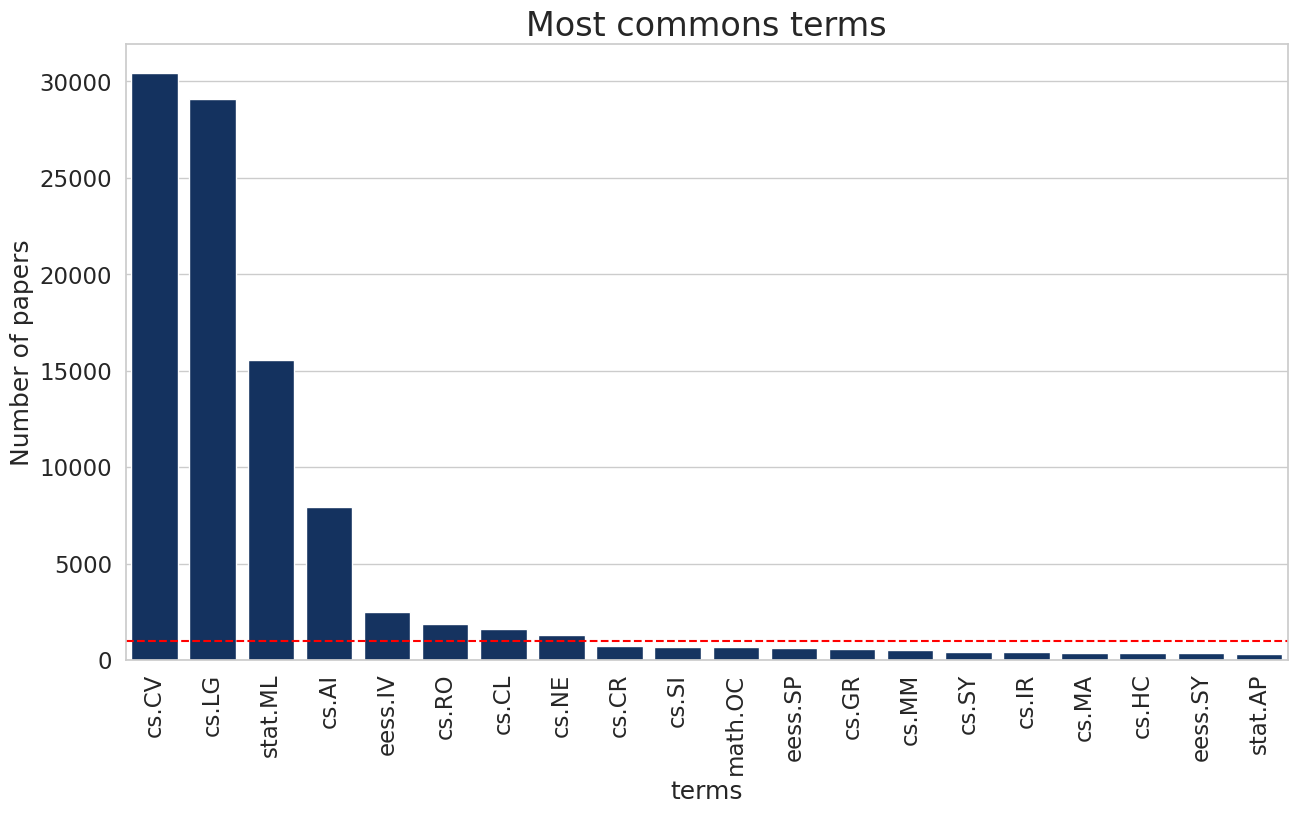

In [26]:
threshold = 1000

plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 


pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['count'].argsort().argsort()  
# IRD: fixed by assigning x & p param names to this line, and printing only highest 20
#  really long tail of other categories otherwise (due to bad formatting)
sns.barplot(x=bar_plot['cat'][:20], y=bar_plot['count'], palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title("Most commons terms", fontsize=24)
plt.ylabel('Number of papers', fontsize=18)
plt.xlabel('terms', fontsize=18)
plt.xticks(rotation='vertical')

plt.show()

In [27]:
description_category_new.head(2)

,titles,summaries,cs.CV,cs.LG,stat.ML,cs.AI,cs.HC,"68U10, 62M05, 62H30, 65C20",cs.NE,physics.geo-ph,...,"68T07 (Primary) 46N10, 94A17 (Secondary)",G.1.2; G.1.6; G.2.1; G.3; I.2.0; I.2.6; I.2.8; I.5.1; I.6; I.6.4,D.1.3; G.4; I.2.8; I.2.11; I.5.3; J.3,I.2.6; I.2.4; I.5.3,"62M10, 62J07, 62P30, 62P12, 37M10",G.3; I.2.3; I.2.6; J.4,G.3; I.2.3; I.2.6; I.2.11; J.4,G.1.3; G.3; I.2.6; I.5.1,I.2.6; G.1.8; G.2.2; I.5.3; I.4.0,I.4.3; G.1.3
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__Commentry__: Visualise if only kept those categories which have over 1k papers, and merge others into others.

In [28]:
main_categories = pd.DataFrame()
main_categories = bar_plot[bar_plot['count']>1000]
categories = main_categories['cat'].values
categories = np.append(categories,'Others')
not_category = []
description_category_new['Others'] = 0

for i in description_category_new.columns[2:]:
    if i not in categories:
        description_category_new['Others'][description_category_new[i] == 1] = 1
        not_category.append(i)

description_category_new.drop(not_category, axis=1, inplace=True)
import warnings  
warnings.filterwarnings('ignore')

/tmp/ipykernel_18162/786777416.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  description_category_new['Others'] = 0
/tmp/ipykernel_18162/786777416.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  description_category_new['Others'][description_category_new[i] == 1] = 1
/tmp/ipykernel_18162/786777416.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  description_category_new['Othe

In [29]:
description_category_new.head()

,titles,summaries,cs.CV,cs.LG,stat.ML,cs.AI,cs.NE,cs.RO,eess.IV,cs.CL,Others
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,1,1,0,0,0,0,0,0,0
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,1,1,0,1,0,0,0,0,0
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...",1,0,0,1,0,0,0,0,0
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,1,0,0,0,0,0,0,0,0
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...",1,1,0,0,0,0,0,0,0


In [30]:
most_common_cat = pd.DataFrame()
most_common_cat['cat'] = description_category_new.columns[2:]
most_common_cat['count'] = description_category_new.iloc[:,2:].sum().values
most_common_cat.sort_values(['count'], inplace=True, ascending=False)
most_common_cat.reset_index(inplace=True, drop=True)
most_common_cat.head()

,cat,count
0,cs.CV,30413
1,cs.LG,29067
2,stat.ML,15578
3,Others,10223
4,cs.AI,7944


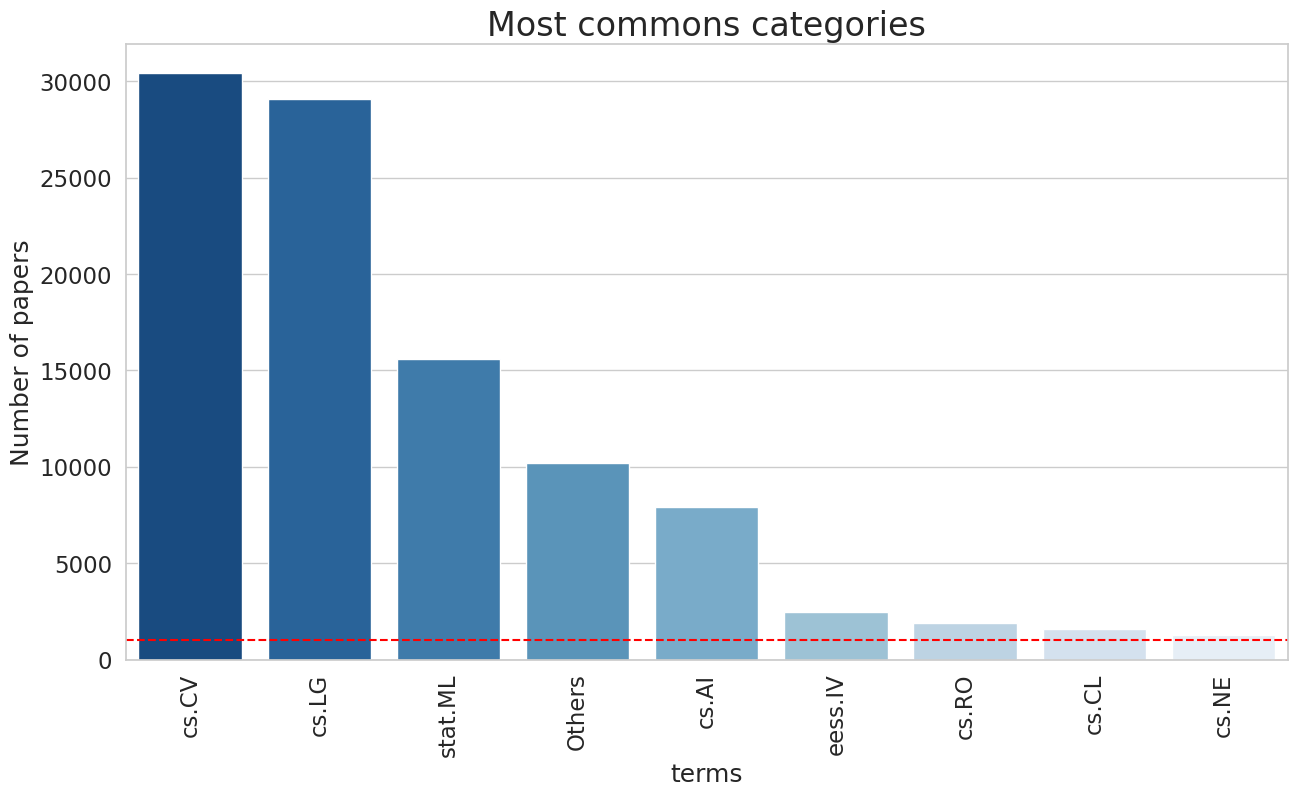

In [31]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 


pal = sns.color_palette("Blues_r", len(most_common_cat))
rank = most_common_cat['count'].argsort().argsort()  

sns.barplot(x=most_common_cat['cat'], y=most_common_cat['count'], palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title("Most commons categories", fontsize=24)
plt.ylabel('Number of papers', fontsize=18)
plt.xlabel('terms', fontsize=18)
plt.xticks(rotation='vertical')

plt.show()

__Commentry__: Keep main categories and ignore rest.

In [32]:
rowSums = description_category_new.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()

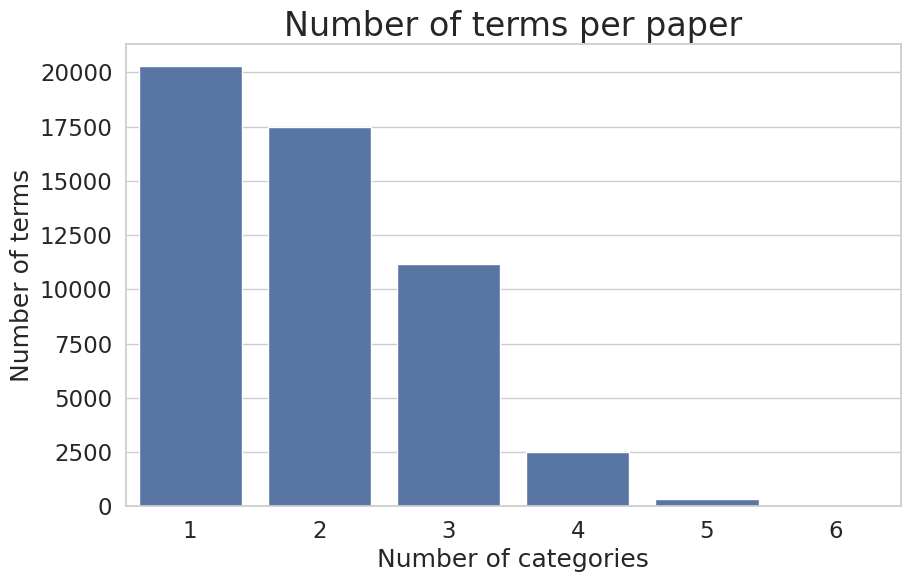

In [33]:
sns.set(font_scale = 1.5)
sns.set_style('whitegrid') 
plt.figure(figsize=(10,6))

sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)
plt.title("Number of terms per paper", fontsize=24)
plt.ylabel('Number of terms', fontsize=18)
plt.xlabel('Number of categories', fontsize=18)

plt.show()

In [34]:
columns=['OneVsAll', 'BinaryRelevance', 'ClassifierChain', 'MultipleOutput','DNN', 'CNN', 'LSTM']
results = pd.DataFrame(columns = columns)
results

,OneVsAll,BinaryRelevance,ClassifierChain,MultipleOutput,DNN,CNN,LSTM


In [35]:
seeds = [1, 43, 678, 90, 135]


In [36]:
t = results.copy()
t

,OneVsAll,BinaryRelevance,ClassifierChain,MultipleOutput,DNN,CNN,LSTM


In [37]:
def decontract(sentence):
    # specific
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)

    # general
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

def cleanPunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub("", sentence)

In [38]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

re_stop_words = re.compile(r"\b(" + "|".join(stopwords) + ")\\W", re.I)

In [39]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [40]:

description_category_new.head()


,titles,summaries,cs.CV,cs.LG,stat.ML,cs.AI,cs.NE,cs.RO,eess.IV,cs.CL,Others
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,1,1,0,0,0,0,0,0,0
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,1,1,0,1,0,0,0,0,0
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...",1,0,0,1,0,0,0,0,0
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,1,0,0,0,0,0,0,0,0
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...",1,1,0,0,0,0,0,0,0


__Commentry__: Data pre-processing - 'clean' up the summaries text

In [41]:
description_category_new['summaries'] = description_category_new['summaries'].str.lower()
description_category_new['summaries'] = description_category_new['summaries'].apply(decontract)
description_category_new['summaries'] = description_category_new['summaries'].apply(cleanPunc)
description_category_new['summaries'] = description_category_new['summaries'].apply(keepAlpha)
description_category_new['summaries'] = description_category_new['summaries'].apply(removeStopWords)
description_category_new['summaries'] = description_category_new['summaries'].apply(stemming)

In [42]:
description_category_new.head()

,titles,summaries,cs.CV,cs.LG,stat.ML,cs.AI,cs.NE,cs.RO,eess.IV,cs.CL,Others
0,Survey on Semantic Stereo Matching / Semantic ...,stereo match one wide use techniqu infer depth...,1,1,0,0,0,0,0,0,0
1,FUTURE-AI: Guiding Principles and Consensus Re...,recent advanc artifici intellig ai combin exte...,1,1,0,1,0,0,0,0,0
2,Enforcing Mutual Consistency of Hard Regions f...,paper propos novel mutual consist network mcne...,1,0,0,1,0,0,0,0,0
3,Parameter Decoupling Strategy for Semi-supervi...,consist train proven advanc semisupervis frame...,1,0,0,0,0,0,0,0,0
4,Background-Foreground Segmentation for Interio...,ensur safeti autom drive correct percept situa...,1,1,0,0,0,0,0,0,0


In [43]:
description_category_new["summaries"][0]
description_category_new["summaries"][1]
description_category_new["summaries"][2]

'paper propos novel mutual consist network mcnet effect exploit unlabel hard region semisupervis medic imag segment mcnet model motiv observ deep model train limit annot prone output high uncertain easili misclassifi predict ambigu region e g adhes edg thin branch imag segment task leverag regionlevel challeng sampl make semisupervis segment model train effect therefor propos mcnet model consist two new design first model contain one share encod multipl sight differ decod e use differ upsampl strategi statist discrep multipl decod output comput denot model uncertainti indic unlabel hard region second new mutual consist constraint enforc one decod probabl output decod soft pseudo label way minim model uncertainti train forc model generat invari lowentropi result challeng area unlabel data order learn general featur represent compar segment result mcnet five stateoftheart semisupervis approach three public medic dataset extens experi two common semisupervis set demonstr superior perform 

In [44]:
description_category_new.shape

(51774, 11)

__Commentry__: identify labels that feature data is to be trained against.

In [45]:
y = description_category_new.columns[2:]
y

Index(['cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'cs.NE', 'cs.RO', 'eess.IV',
       'cs.CL', 'Others'],
      dtype='object')

__Commentry__: Express permutations of multiple labels in our label data. 
Note: I believe there must be more permuations than this so, but suspicious

In [46]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(description_category_new.columns[2:])
y

array([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]])

In [47]:
multilabel.classes_

array(['.', 'A', 'C', 'E', 'G', 'I', 'L', 'M', 'N', 'O', 'R', 'V', 'a',
       'c', 'e', 'h', 'r', 's', 't'], dtype=object)

__Commentry__:Split into training and test data sets.
Transform summaries training data into binary expressed (1-3 ngrams)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(description_category_new['summaries'], 
                                                    description_category_new[description_category_new.columns[2:]], 
                                                    test_size=0.3, 
                                                    random_state=seeds[4], 
                                                    shuffle=True)
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)

textual_X_test = X_test
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [55]:
# Get a 'processed' text value and its vectorised equivalent
print(textual_X_test.head())

print("Item at loc 0")
print("Item index id=",textual_X_test.index.tolist()[0])
X_test_item0_index=textual_X_test.index.tolist()[0];
X_test_item0_orig_record = papers.iloc[X_test_item0_index]
print(papers.iloc[X_test_item0_index])
print(textual_X_test.iloc[0])
print("vectorised text:: getnnz=",X_test.getrow(0).getnnz())
print(X_test.getrow(0))

X_test_item0_stemmed = textual_X_test.iloc[0]
X_test_item0_vectorised =  X_test.getrow(0)


print("Item loc 1")
print("Item index id=",textual_X_test.index.tolist()[1])
X_test_item1_index=textual_X_test.index.tolist()[1];
X_test_item1_orig_record = papers.iloc[X_test_item1_index]
print(papers.iloc[X_test_item1_index])
print(textual_X_test.iloc[1])
print("vectorised text:: getnnz=",X_test.getrow(1).getnnz())
print(X_test.getrow(1))
X_test_item1_stemmed = textual_X_test.iloc[1]
X_test_item1_vectorised =  X_test.getrow(1)


# print(type(textual_X_test))
# print(textual_X_test.index)
# print(type(textual_X_test.index))


13697    deep learn network typic train stochast gradie...
5001     knowledg distil kd popular method train effici...
24758    connectionist tempor classif ctc attent mechan...
30746    paper present supervisionbyregistr unsupervis ...
20325    modern machin learn algorithm adopt rang signa...
Name: summaries, dtype: object
Item at loc 0
Item index id= 13697
titles       Extrapolation for Large-batch Training in Deep...
summaries    Deep learning networks are typically trained b...
terms                                     ['cs.LG', 'stat.ML']
Name: 13697, dtype: object
deep learn network typic train stochast gradient descent sgd method iter improv model paramet estim gradient small fraction train data major roadblock face increas batch size substanti fraction train data improv train time persist degrad perform general gap address issu recent work propos add small perturb model paramet comput stochast gradient report improv general perform due smooth effect howev approach poor understo

In [50]:
import pickle

pickle.dump(vectorizer, open("vectorizer.pickle", "wb"))

__Commentry__: Train against LogicsticRegression ML model - one for each label/category
Note how perform drops for less frequent labels (~0.5 ish)

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier


LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
accuracy = 0
for category in description_category_new.columns[2:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    LR_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = LR_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC score is {}'.format(roc_auc_score(y_test[category],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(accuracy/len(description_category_new.columns[2:])))

**Processing cs.CV titles...**
AUC ROC score is 0.9281525161813028


**Processing cs.LG titles...**
AUC ROC score is 0.8701675331428619


**Processing stat.ML titles...**
AUC ROC score is 0.7944829712437356


**Processing cs.AI titles...**
AUC ROC score is 0.6053886714655579


**Processing cs.NE titles...**
AUC ROC score is 0.5


**Processing cs.RO titles...**
AUC ROC score is 0.5454052194996025


**Processing eess.IV titles...**
AUC ROC score is 0.5035161744022504


**Processing cs.CL titles...**
AUC ROC score is 0.5429136475437081


**Processing Others titles...**
AUC ROC score is 0.5805154265056798


Test averaged AUC ROC is 0.9094830361166549


__Commentry__: Train MultinomialNB model - one for each category;
Note again performance drops for less frequent labels (~0.5 ish)


In [52]:
from sklearn.naive_bayes import MultinomialNB

NB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None)))])
accuracy = 0
for category in description_category_new.columns[2:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    NB_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = NB_pipeline.predict(X_test)
    accuracy = accuracy + accuracy_score(y_test[category], prediction)
    print('AUC ROC is {}'.format(roc_auc_score(y_test[category],prediction)))
    print("\n")

print('Test averaged AUC ROC is {}'.format(accuracy/len(description_category_new.columns[2:])))

**Processing cs.CV titles...**
AUC ROC is 0.8218918126423549


**Processing cs.LG titles...**
AUC ROC is 0.8500678009270449


**Processing stat.ML titles...**
AUC ROC is 0.5085810522661748


**Processing cs.AI titles...**
AUC ROC is 0.5


**Processing cs.NE titles...**
AUC ROC is 0.5


**Processing cs.RO titles...**
AUC ROC is 0.5


**Processing eess.IV titles...**
AUC ROC is 0.5


**Processing cs.CL titles...**
AUC ROC is 0.5


**Processing Others titles...**
AUC ROC is 0.5


Test averaged AUC ROC is 0.8809702640256944


__Commentry__: Train each against LinearSVC model for each category(ie label)
Note performance pretty good for all labels

In [88]:
from sklearn.svm import LinearSVC
import joblib

SVC_pipeline = Pipeline([('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))])

accuracy = 0
for category in description_category_new.columns[2:]:
    print('**Processing {} titles...**'.format(category))
    
    # Training logistic regression model on train data
    SVC_pipeline.fit(X_train, y_train[category])
    
    # calculating test accuracy
    prediction = SVC_pipeline.predict(X_test)
    accuracy = accuracy + roc_auc_score(y_test[category], prediction)
    print('F1-score is {}'.format(roc_auc_score(y_test[category],prediction)))
    print("\n")

    X_test_item0_prediction = SVC_pipeline.predict(X_test_item0_vectorised)
    confidence_item0 = SVC_pipeline.decision_function(X_test_item0_vectorised)
    print("Item0:",X_test_item0_prediction,":", confidence_item0)
    X_test_item1_prediction = SVC_pipeline.predict(X_test_item1_vectorised)
    confidence_item1 = SVC_pipeline.decision_function(X_test_item1_vectorised)
    print("Item1:",X_test_item1_prediction,":", confidence_item1)

    # Added by Ivor
    joblib.dump(SVC_pipeline, 'svc_pipeline_model_{}.pkl'.format(category))


print('Test averaged f1-score is {}'.format(accuracy/len(description_category_new.columns[2:])))

**Processing cs.CV titles...**
F1-score is 0.9460162457189264


Item0: [0] : [-0.62534359]
Item0: [1] : [0.85393756]
**Processing cs.LG titles...**
F1-score is 0.9098863184804102


Item0: [1] : [1.07358816]
Item0: [0] : [-0.38214255]
**Processing stat.ML titles...**
F1-score is 0.8420889870830666


Item0: [1] : [0.61363072]
Item0: [0] : [-0.67324851]
**Processing cs.AI titles...**
F1-score is 0.7586071376274108


Item0: [0] : [-0.63367419]
Item0: [0] : [-0.91564771]
**Processing cs.NE titles...**
F1-score is 0.6554395920733389


Item0: [0] : [-0.9527731]
Item0: [0] : [-0.94796826]
**Processing cs.RO titles...**
F1-score is 0.7383787807455445


Item0: [0] : [-1.08625322]
Item0: [0] : [-1.06506515]
**Processing eess.IV titles...**
F1-score is 0.7143179703413465


Item0: [0] : [-1.05954507]
Item0: [0] : [-1.21166663]
**Processing cs.CL titles...**
F1-score is 0.7848733630259921


Item0: [0] : [-0.9531743]
Item0: [0] : [-1.10174313]
**Processing Others titles...**
F1-score is 0.74406623689

In [82]:
# discover how to call predict with a single item
print(type(prediction))
print("X_test size=",X_test.size)
print("Prediction size=",prediction.size)
print(prediction.tolist())
print("---")
# print(type(X_test))
# print(type(X_test_item0_vectorised))
# print(X_test)
# print("---")
# print(X_test_item0_vectorised)
# X_test_item0_prediction = SVC_pipeline.predict(X_test_item0_vectorised)
# print(X_test_item0_prediction)
# X_test_item1_prediction = SVC_pipeline.predict(X_test_item1_vectorised)
# print(X_test_item1_prediction)


<class 'numpy.ndarray'>
X_test size= 3354214
Prediction size= 15533
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

__Extension__: Save the SVC model for future use.

In [68]:
pip install joblib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [69]:

# from sklearn.externals 
# import joblib
# joblib.dump(SVC_pipeline, 'svc_pipeline_model.pkl')
# ['model.pkl']


['model.pkl']

In [70]:
description_category_new['summaries']


0        stereo match one wide use techniqu infer depth...
1        recent advanc artifici intellig ai combin exte...
2        paper propos novel mutual consist network mcne...
3        consist train proven advanc semisupervis frame...
4        ensur safeti autom drive correct percept situa...
                               ...                        
51769    address problem analyz set noisi timevari sign...
51770    discuss method track individu molecul global o...
51771    attempt set mathemat foundat immunolog amino a...
51772    diffus tensor imag dti allow estim posit orien...
51773    mass spectrometri ms import techniqu chemic pr...
Name: summaries, Length: 51774, dtype: object

In [71]:
pip install keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


__Commentry__: Also try Deep Learning model. Using 'pre-processed' raw text.

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(description_category_new['summaries'])
sequences = tokenizer.texts_to_sequences(description_category_new['summaries'])
x = pad_sequences(sequences, maxlen=200)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    description_category_new[description_category_new.columns[2:]], 
                                                    test_size=0.3, 
                                                    random_state=seeds[4])

__Commentry__: whats this?

In [ ]:
most_common_cat['class_weight'] = len(most_common_cat) / most_common_cat['count']
class_weight = {}
for index, label in enumerate(categories):
    class_weight[index] = most_common_cat[most_common_cat['cat'] == categories]['class_weight'].values[0]
    
most_common_cat.head()

In [ ]:
num_classes = y_train.shape[1]
max_words = len(tokenizer.word_index) + 1
maxlen = 200

In [ ]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPool1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf

model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
#model.add(Dropout(0.2))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer=Adam(0.015), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
callbacks = [
    ReduceLROnPlateau(),
    #EarlyStopping(patience=10),
    ModelCheckpoint(filepath='model-simple.h5', save_best_only=True)
]


history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=25,
                    batch_size=64,
                    validation_split=0.3,
                    callbacks=callbacks)

In [ ]:
cnn_model = model
metrics = cnn_model.evaluate(X_test, y_test)
print("{}: {}".format(cnn_model.metrics_names[1], metrics[1]))

In [ ]:
results.loc[4,'DNN'] = metrics[1]
results

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D

filter_length = 300

model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
#model.add(Dropout(0.5))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=25,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

In [ ]:
cnn_model = model
metrics = cnn_model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

In [ ]:
results.loc[4,'CNN'] = metrics[1]
results